In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
from skimage import io
import tensorflow as tf
import keras
from keras import backend as K 
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.layers import GlobalAveragePooling2D, Dense, Activation, BatchNormalization, Dropout, Input
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
import cv2
from keras.applications.vgg16 import  VGG16, preprocess_input
from skimage.util import view_as_windows 
from scipy.io import loadmat
from scipy.stats import pearsonr, spearmanr

<h1>Loading test Set </h1>

In [3]:
!wget http://www.polytech.univ-nantes.fr/autrusseau-f/Databases/SelectiveEncryption/SelectiveEncryption.zip

--2021-09-22 23:39:38--  http://www.polytech.univ-nantes.fr/autrusseau-f/Databases/SelectiveEncryption/SelectiveEncryption.zip
Resolving www.polytech.univ-nantes.fr (www.polytech.univ-nantes.fr)... 193.52.104.60, 2001:660:7220:386:193:52:104:60
Connecting to www.polytech.univ-nantes.fr (www.polytech.univ-nantes.fr)|193.52.104.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49926550 (48M) [application/zip]
Saving to: ‘SelectiveEncryption.zip’

SelectiveEncryption 100%[===================>]  47.61M  18.0MB/s    in 2.7s    

2021-09-22 23:39:41 (18.0 MB/s) - ‘SelectiveEncryption.zip’ saved [49926550/49926550]



In [4]:
!unzip /content/SelectiveEncryption.zip

Archive:  /content/SelectiveEncryption.zip
   creating: SelectiveEncryption/
  inflating: SelectiveEncryption/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/SelectiveEncryption/
  inflating: __MACOSX/SelectiveEncryption/._.DS_Store  
   creating: SelectiveEncryption/images/
  inflating: SelectiveEncryption/images/cimg6013-001-iwind_ec.pgm  
  inflating: SelectiveEncryption/images/cimg6013-001-iwind_nec.pgm  
  inflating: SelectiveEncryption/images/cimg6013-001-trad.pgm  
  inflating: SelectiveEncryption/images/cimg6013-001-trunc.pgm  
  inflating: SelectiveEncryption/images/cimg6013-007-iwind_ec.pgm  
   creating: __MACOSX/SelectiveEncryption/images/
  inflating: __MACOSX/SelectiveEncryption/images/._cimg6013-007-iwind_ec.pgm  
  inflating: SelectiveEncryption/images/cimg6013-007-iwind_nec.pgm  
  inflating: __MACOSX/SelectiveEncryption/images/._cimg6013-007-iwind_nec.pgm  
  inflating: SelectiveEncryption/images/cimg6013-007-trad.pgm  
  inflating: __MACOSX/SelectiveEncrypti

In [5]:
test = pd.read_csv('/content/drive/MyDrive/Projet-5-em/Project-kadid10k/IVC_test.csv')
test.head()

,name,ground_truth
0,CIMG7593-001-iwind_ec.pgm,0.228571
1,CIMG7593-001-iwind_nec.pgm,0.200000
2,CIMG7593-014-iwind_ec.pgm,0.847619
3,CIMG7593-res-0.pgm,0.209524
4,CIMG7593-res-2.pgm,0.276190


# Loading our trained model

In [6]:
model = keras.models.load_model('/content/drive/MyDrive/Projet-5-em/Project-kadid10k/MultiOut-VGG16-DOC/VGG16MAE-04-06-IVC.h5')

# Model Testing

In [7]:
y= []

for pos in range(0, len(test), 1):
  temp = test.iloc[pos:pos + 1] 

  for encimg in temp.name:
    encrypted_image = image.load_img('/content/SelectiveEncryption/images/'+encimg)
    encrypted_image = image.img_to_array(encrypted_image)

    patches = view_as_windows(encrypted_image,(240, 240, 3),(240, 360, 3)).reshape((-1,240,240,3)) 

    for i in range(4):
      resized = cv2.resize(patches[i], (224,224))
      encrypted_batch = np.expand_dims(resized, axis=0)
      encrypted_batch = preprocess_input(encrypted_batch) 

      y.append(model.predict(encrypted_batch))

In [8]:
image_s = []

for val in y:
  image_s.append(val[0][0])

In [9]:
iq = []
som, j = 0, 1
for elt in image_s:
  som += elt
  if j >= 4:
    iq.append(som/4)
    j = 0
    som = 0
  j = j+1

iq = np.array(iq)
iq.shape

(40,)

#Performance visualization

In [10]:
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

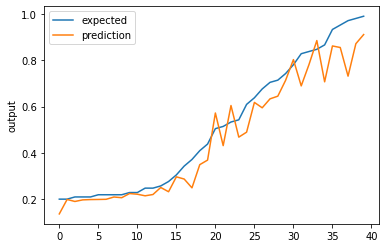

SpearmanrResult(correlation=0.9827726924014933, pvalue=1.789252101744169e-29)
PearsonrResult (0.9790727360293136, 6.98583749933687e-28)


In [11]:
chart_regression(iq, test.ground_truth.values)
print(spearmanr(test.ground_truth.values, iq))
print('PearsonrResult',pearsonr(test.ground_truth.values, iq))